In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

REPORT_FILE_PATH = Path('../llm-answer-results/robojudge_human_results.csv')

FIGURE_FILE_PATH = Path('../llm-answer-results/figures/')
df = pd.read_csv(REPORT_FILE_PATH)
df.pop('Časová značka')

sns.set_theme()

In [2]:
REFERENCE_PATH = Path('../../datasets/answering/reference/')

question_ids = [file.stem for file in REFERENCE_PATH.iterdir()]

In [3]:
answer_indices = []
question_indices = []
for i, q in zip(range(1,21), question_ids):
    answer_indices.extend([f'gpt_{i}',f'llama_{i}',f'vicuna_{i}'])
    question_indices.extend([q,q,q])

In [4]:
for ind, col in zip(answer_indices, df.columns):
    df.rename(columns={col: ind}, inplace=True)

In [5]:
average_df = pd.DataFrame(columns=['llm_type', 'average_score', 'question_id'])

for ind, col in enumerate(df.columns):
    new_row = pd.DataFrame({'llm_type': col.split('_')[0], "average_score": np.mean(df[col]), 'question_id': question_indices[ind]}, index=[ind])
    average_df = pd.concat([average_df, new_row])

/tmp/ipykernel_85105/4247139390.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  average_df = pd.concat([average_df, new_row])


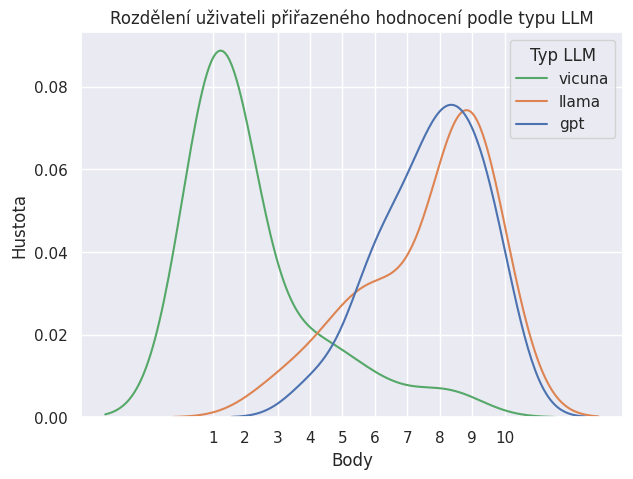

In [6]:
f, ax = plt.subplots(figsize=(7, 5))
# sns.despine(f)

ax.set_xticks(range(1,11))
ax.set_xlabel('Body')
ax.set_ylabel('Hustota')
g =sns.kdeplot(average_df, x='average_score', hue='llm_type').set_title('Rozdělení uživateli přiřazeného hodnocení podle typu LLM').set
plt.legend(title='Typ LLM', labels=['vicuna', 'llama', 'gpt'])

plt.savefig(FIGURE_FILE_PATH / 'human_kde.png')

In [7]:
result_table = average_df.groupby('llm_type')['average_score'].describe()
result_table['std'] = result_table['std'].round(2)
result_table['mean'] = result_table['mean'].round(2)
result_table['50%'] = result_table['50%'].round(2)
result_table.rename(columns={'count': 'počet', 'mean': 'průměr', 'std': 'směrodatná odchylka', '50%': 'medián'}, inplace=True)
result_table.index.names = ['typ LLM']
result_table[['počet', 'průměr', 'směrodatná odchylka', 'medián']].to_csv(FIGURE_FILE_PATH/'human_score_by_type.csv')

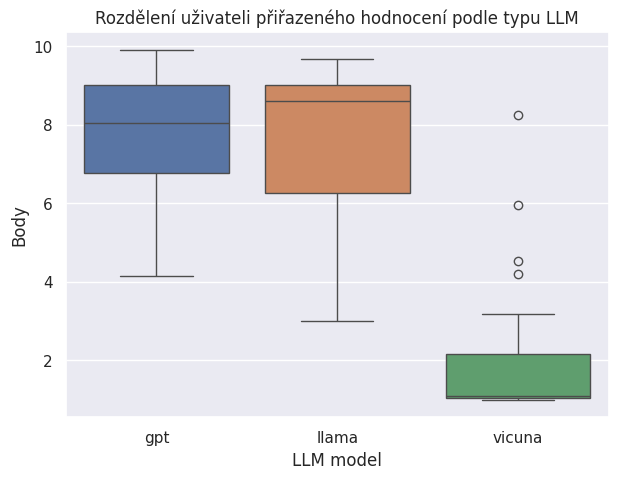

In [8]:
f, ax = plt.subplots(figsize=(7, 5))

sns.boxplot(data=average_df, y='average_score', x='llm_type', hue='llm_type', width=0.8).set_title('Rozdělení uživateli přiřazeného hodnocení podle typu LLM')

ax.set_ylabel('Body')
ax.set_xlabel('LLM model')
# plt.legend(title='Typ LLM')

plt.savefig(FIGURE_FILE_PATH / 'human_boxplot.png')

In [9]:
auto_df = pd.read_csv('../llm-answer-results/robojudge_auto_results.csv')
auto_df['question_id'] = auto_df.apply(lambda x: x['file_name'].split('.')[0], axis=1)
auto_df = auto_df[auto_df['question_id'].isin(question_ids)]
auto_df.reset_index(inplace=True)

In [10]:
auto_df.groupby('llm_type')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
llm_type,,,,,,,,
gpt,20.0,6.40,3.704904,1.0,3.5,7.5,10.0,10.0
llama,20.0,6.10,3.796120,1.0,2.0,8.0,10.0,10.0
vicuna,20.0,2.25,2.425197,0.0,1.0,1.0,2.5,9.0


In [11]:
merged_df = average_df.copy()
merged_df['auto_score'] = np.NaN

In [12]:
for llm_ind, llm_type in enumerate(['gpt', 'llama', 'vicuna']):
    for ind, (_, row) in enumerate(auto_df[auto_df['llm_type'] == llm_type].iterrows()):
        merged_df.at[ind * 3 + llm_ind, 'auto_score'] = row['score']
        # max(1, row['score'])

In [13]:
from scipy import stats

for llm_type in ['gpt', 'llama', 'vicuna']:
    res = stats.ks_2samp(merged_df[merged_df['llm_type'] == llm_type]['average_score'], merged_df[merged_df['llm_type'] == llm_type]['auto_score'])
    print(res)

KstestResult(statistic=0.4, pvalue=0.08105771161340149, statistic_location=4.0, statistic_sign=-1)
KstestResult(statistic=0.35, pvalue=0.17453300569806826, statistic_location=4.0, statistic_sign=-1)
KstestResult(statistic=0.55, pvalue=0.00396729438660086, statistic_location=1.0, statistic_sign=-1)


In [23]:
from scipy import stats

for llm_type in ['gpt', 'llama', 'vicuna']:
    for evaluation_type in ['average_score', 'auto_score']:
        res = stats.shapiro(
            merged_df[merged_df['llm_type'] == llm_type][evaluation_type])
        print(llm_type, evaluation_type,res)

gpt average_score ShapiroResult(statistic=0.9576286354138365, pvalue=0.497632849874689)
gpt auto_score ShapiroResult(statistic=0.8113237237685887, pvalue=0.0012809045644432368)
llama average_score ShapiroResult(statistic=0.8594973804163748, pvalue=0.0077216635418065485)
llama auto_score ShapiroResult(statistic=0.7986210913167497, pvalue=0.0008240608322022176)
vicuna average_score ShapiroResult(statistic=0.6722274509216619, pvalue=1.821862541183873e-05)
vicuna auto_score ShapiroResult(statistic=0.6751570589716751, pvalue=1.970698055986741e-05)


In [20]:
from scipy import stats

for llm_type in ['gpt', 'llama', 'vicuna']:
    res = stats.ttest_rel(merged_df[merged_df['llm_type'] == llm_type]['average_score'], merged_df[merged_df['llm_type'] == llm_type]['auto_score'])
    print(res)

TtestResult(statistic=1.6827087887673209, pvalue=0.10879263104782108, df=19)
TtestResult(statistic=1.4999228229537989, pvalue=0.1500683773720208, df=19)
TtestResult(statistic=-0.051577150243474736, pvalue=0.9594040234665064, df=19)


Paired + cannot assume normal distribution

In [15]:
for llm_type in ['gpt', 'llama', 'vicuna']:
    res = stats.wilcoxon(merged_df[merged_df['llm_type'] == llm_type]['average_score'], merged_df[merged_df['llm_type'] == llm_type]['auto_score'])
    print(res)

WilcoxonResult(statistic=72.0, pvalue=0.2305126190185547)
WilcoxonResult(statistic=69.0, pvalue=0.1893482208251953)
WilcoxonResult(statistic=70.0, pvalue=0.4986365621719102)


/home/rehoumir/.cache/pypoetry/virtualenvs/robojudge-pJLOKXWb-py3.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


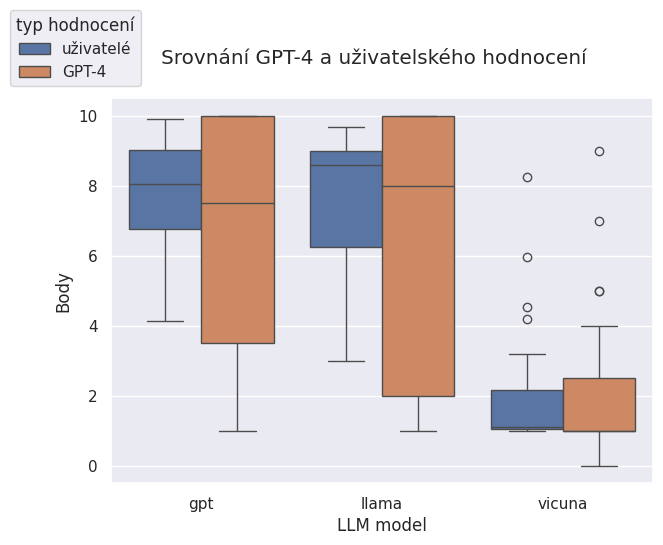

In [16]:
regrouped_df = merged_df.melt(id_vars=['llm_type'], value_vars=['average_score', 'auto_score'])
regrouped_df['variable'] = regrouped_df['variable'].replace({'average_score': 'člověk', 'auto_score': "automatické"})
regrouped_df.rename(columns={"variable": "typ hodnocení"}, inplace=True)

f, ax = plt.subplots(figsize=(7, 5))

f.suptitle('Srovnání GPT-4 a uživatelského hodnocení')
g =sns.boxplot(regrouped_df, ax=ax, y='value', x='llm_type', hue='typ hodnocení')
sns.move_legend(g, "upper left", bbox_to_anchor=(-0.2, 1.25))

for t, l in zip(g.get_legend().texts, ['uživatelé', 'GPT-4']):
    t.set_text(l)
ax.set(xlabel='LLM model', ylabel='Body')

f.savefig(FIGURE_FILE_PATH / 'comp_boxplot.png')

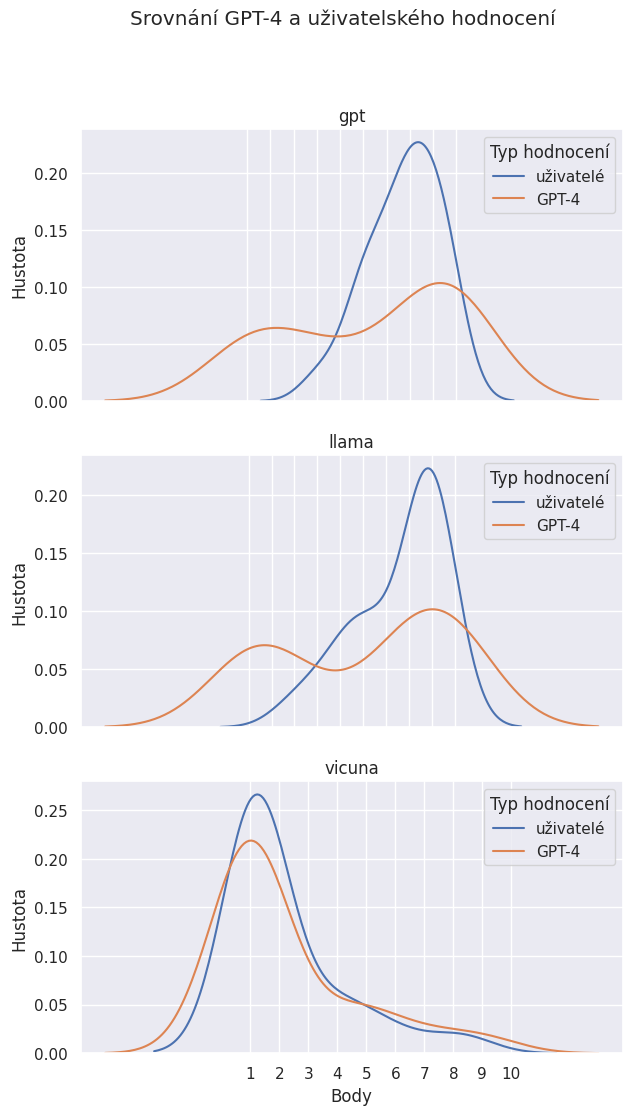

In [17]:
# Create plots for each llm_type to compare auto vs human distributions of score
f, axes = plt.subplots(3, figsize=(7, 12))
# sns.despine(f)

for ax, llm_type in zip(axes, ['gpt', 'llama', 'vicuna']):
    ax.set_xticks(range(1,11))
    f.suptitle('Srovnání GPT-4 a uživatelského hodnocení')
    ax.set_title(llm_type)
    g =sns.kdeplot(merged_df[merged_df['llm_type'] == llm_type], ax=ax, x='average_score')
    g =sns.kdeplot(merged_df[merged_df['llm_type'] == llm_type], ax=ax, x='auto_score')
    ax.legend(title='Typ hodnocení', labels=['uživatelé', 'GPT-4'])

for ax in axes.flat:
    ax.set(xlabel='Body', ylabel='Hustota')
for ax in axes.flat:
    ax.label_outer()

f.savefig(FIGURE_FILE_PATH / 'comp_kde.png')